# Step 0: Importing libraries
Import libraries for the task

In [1]:
from datetime import datetime

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Step 1 – Load and Inspect the Data

Load the dataset into a pandas daraframa

In [31]:
# Path to csv file
dataFile = "../datasets/Dataset_for_Q2.csv"

# load csv file
df = pd.read_csv(dataFile)

# Basic structure fo the dataset

print("\n################## Shape of dataset is:##################  \n", df.shape)
print("\n################## Columns of dataset are:##################  \n", df.columns.tolist())
print("\n################## Top 5 rows of dataset are:##################  \n", df.head(5))
print("\n################## Last 5 rows of dataset are:##################  \n", df.tail(5))

# Check for missing values
print("\n Number of missing values: \n", df.isna().sum())


# Summary statistics
print("\n##################Statistical Summary of the dataset: ##################\n", df.describe(include="all"))
print("\n################## Dataframe Summary: ##################\n")
df.info()


################## Shape of dataset is:##################  
 (1000, 5)

################## Columns of dataset are:##################  
 ['Age', 'Income', 'SpendingScore', 'NumPurchases', 'LoyaltyLevel']

################## Top 5 rows of dataset are:##################  
     Age       Income  SpendingScore  NumPurchases LoyaltyLevel
0  69.0  53154.57691      58.684106          15.0       Silver
1  32.0  40389.61115     118.300716          17.0       Silver
2   NaN  56045.80144     120.000000          15.0       Silver
3  78.0  22736.86719      99.061927          19.0         Gold
4  38.0  23440.89643     120.000000          19.0         Gold

################## Last 5 rows of dataset are:##################  
       Age       Income  SpendingScore  NumPurchases LoyaltyLevel
995  23.0  58113.93797      55.125156          15.0       Silver
996   NaN  47842.03199      35.026396           8.0       Silver
997  40.0  29213.83962      15.995805          16.0       Bronze
998  64.0  21001.0395

## 1. Missing Value Treatment — Best Method: Group-Wise Median Imputation

The most appropriate method for this dataset is group-wise median imputation by LoyaltyLevel. Because the numerical features (Age, Spending Score, Number of Purchases) are skewed and customer behavior varies by loyalty tier, imputing the median within each LoyaltyLevel group preserves natural customer segments while remaining robust to outliers.

#### Why This Method Is Best

- Handles skew well: The median is resistant to extreme values, unlike the mean.
- Respects customer segmentation: Bronze, Silver, Gold, and Platinum customers differ in spending and activity; imputing within each group keeps these differences intact.
- Preserves dataset size: No rows are removed, which is important for clustering.

#### Why Alternatives Are Weaker

- Global mean/median: Ignores loyalty tiers and distorts cluster structure.
- Row deletion: Removes up to 20% of records, causing data loss and bias.
- KNN imputation: More complex and sensitive to scaling/outliers; unnecessary when loyalty groups already provide a clear structure.

In [34]:
# Copy the dataset
df_imputed = df.copy()

numeric_cols = ["Age", "Income", "SpendingScore", "NumPurchases"]
group_col = "LoyaltyLevel"

for col in numeric_cols:
    if df_imputed[col].isna().sum() > 0:
        df_imputed[col] = df_imputed.groupby(group_col)[col].transform(
            lambda x: x.fillna(x.median())
        )
# Double-check missing values after imputation

print(df_imputed.isna().sum())

Age              0
Income           0
SpendingScore    0
NumPurchases     0
LoyaltyLevel     0
dtype: int64


## 2. Outlier Handling — Reason for Choosing IQR-Based Winsorization (Capping)

IQR-based winsorization is the best method for this dataset because it limits the influence of extreme high values in Income and NumPurchases without removing those customers entirely. Since clustering algorithms like k-means are sensitive to large numeric distances, capping outliers ensures they don’t distort cluster centers while still keeping legitimate high-value customers (e.g., heavy spenders) in the analysis.

#### Why This Method Is Best
- Robust to skewed data: The IQR rule handles asymmetry in Income and Purchasing behavior better than z-scores.
- Prevents distortion: Capping reduces the leverage of extreme values that could pull cluster centroids away from the majority of customers.
- Retains important cases: High-spending or high-purchase customers are kept in the dataset rather than being deleted, preserving meaningful customer segments.

#### Why Alternatives Are Inferior
- Removing outliers: Deletes valuable high-spending customers and harms cluster interpretability.
- Z-score filtering: Assumes normality, which does not hold here due to skewed distributions.
- Doing nothing: A few extreme values would dominate distance calculations and produce biased clusters.

In [4]:
# Columns where outliers will be capped
outlier_cols = ["Income", "NumPurchases"]

def winsorize_iqr(series):
    """
    Caps values above the upper IQR fence: Q3 + 1.5 * IQR.
    This preserves extreme high customers but limits their influence.
    """
    q1 = series.quantile(0.25)
    q3 = series.quantile(0.75)
    iqr = q3 - q1
    upper_bound = q3 + 1.5 * iqr

    return np.where(series > upper_bound, upper_bound, series)

# Apply winsorization
df_winsorized = df_imputed.copy()
for col in outlier_cols:
    df_winsorized[col] = winsorize_iqr(df_winsorized[col])

# 🔹 Round the columns to 2 decimal places before saving
df_winsorized[outlier_cols] = df_winsorized[outlier_cols].round(2)

# Show capped values
print("Max values after IQR capping and rounding:")
print(df_winsorized[outlier_cols].max())

# Save processed dataset
output_path = "../datasets/output/Dataset_for_Q2_after_outlier_capping.csv"
df_winsorized.to_csv(output_path, index=False)

print(f"\nFile saved as: {output_path}")

Max values after IQR capping and rounding:
Income          91524.68
NumPurchases       27.00
dtype: float64

File saved as: ../datasets/output/Dataset_for_Q2_after_outlier_capping.csv


### Outlier Visualizaion of *Income* and *NumPurchase* before and after handling outlier

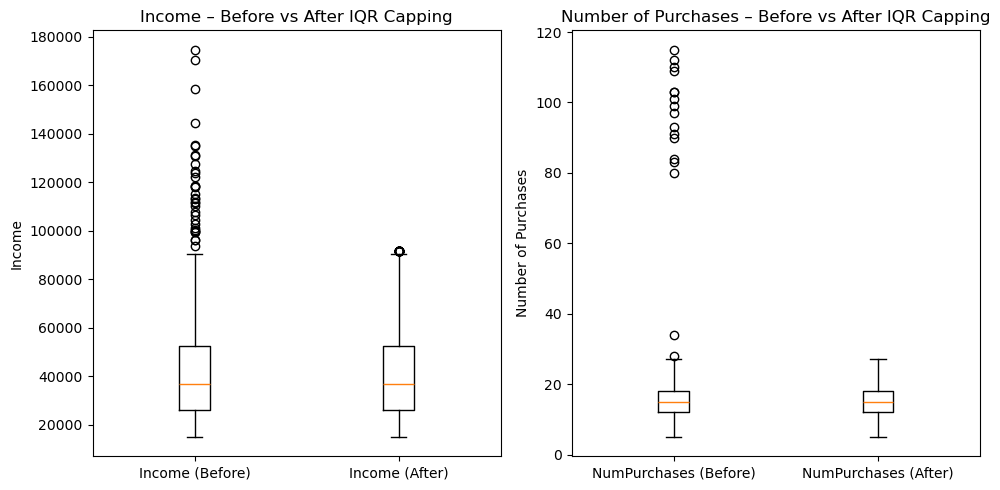

In [5]:
# ---------------------------
# Boxplots: before vs after
# ---------------------------
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Income
axes[0].boxplot(
    [df["Income"].dropna(), df_winsorized["Income"].dropna()],
    tick_labels=["Income (Before)", "Income (After)"]
)
axes[0].set_title("Income – Before vs After IQR Capping")
axes[0].set_ylabel("Income")

# NumPurchases
axes[1].boxplot(
    [df["NumPurchases"].dropna(), df_winsorized["NumPurchases"].dropna()],
    tick_labels=["NumPurchases (Before)", "NumPurchases (After)"]
)
axes[1].set_title("Number of Purchases – Before vs After IQR Capping")
axes[1].set_ylabel("Number of Purchases")

plt.tight_layout()
plt.show()


## 3. Normalization / Scaling — Best Method: Robust Scaling
Chosen Method: RobustScaler (Median = 0, IQR = 1)

Reason:
The dataset contains skewed distributions (especially in Income and NumPurchases) and still has moderate outliers even after IQR capping. Robust Scaling normalizes all features by subtracting the median and dividing by the IQR, making it far more stable than standardization or min–max scaling when dealing with skew and remaining outliers.

### Why This Method Is Best
- Resistant to outliers: Median and IQR are not distorted by extreme values.
- Handles skewed variables well (Income, Purchases).
- Makes all features comparable for distance-based clustering (e.g., K-means).
- Preserves relative spacing of most observations better than min–max.

### Why Alternatives Are Inferior
- Min–Max Scaling: Highly sensitive to outliers; one very large Income compresses the rest into a tiny range.
- Standardization (Z-score): Uses mean and standard deviation → both influenced heavily by skewed distributions.

### No Scaling:
- Income (in thousands) would dominate distances over Age, SpendingScore, etc.
- Clustering becomes meaningless.

In [6]:
from sklearn.preprocessing import RobustScaler

# Load your cleaned dataset after
# missing value imputation + outlier capping
# --------------------------------------
df = df_winsorized.copy()   # or load from file if needed:
df = pd.read_csv("../datasets/output/Dataset_for_Q2_after_outlier_capping.csv")

# --------------------------------------
# Ordinal encoding for LoyaltyLevel
# (required before scaling)
# --------------------------------------
loyalty_order = {"Bronze": 1, "Silver": 2, "Gold": 3, "Platinum": 4}
df["LoyaltyLevel_Encoded"] = df["LoyaltyLevel"].map(loyalty_order)

# --------------------------------------
# Select features for clustering
# --------------------------------------
features_for_clustering = [
    "Age",
    "Income",
    "SpendingScore",
    "NumPurchases",
    "LoyaltyLevel_Encoded"
]

# --------------------------------------
# Apply RobustScaler
# --------------------------------------
scaler = RobustScaler()
scaled_values = scaler.fit_transform(df[features_for_clustering])

# Convert results to DataFrame
df_scaled = pd.DataFrame(
    scaled_values,
    columns=[f"{col}_scaled" for col in features_for_clustering]
)

# --------------------------------------
# Combine scaled values with original dataset
# --------------------------------------
df_final_scaled = pd.concat([df.reset_index(drop=True), df_scaled], axis=1)

# --------------------------------------
# Save final clustering-ready dataset
# --------------------------------------
output_path = "../datasets/output/Dataset_for_Q2_scaled_for_clustering.csv"
df_final_scaled.to_csv(output_path, index=False)

print("Robust scaling complete.")
print("Saved preprocessed dataset to:", output_path)

df_final_scaled.head()

Robust scaling complete.
Saved preprocessed dataset to: ../datasets/output/Dataset_for_Q2_scaled_for_clustering.csv


Age    Income  SpendingScore  NumPurchases LoyaltyLevel  \
0  69.0  53154.58      58.684106          15.0       Silver   
1  32.0  40389.61     118.300716          17.0       Silver   
2  50.0  56045.80     120.000000          15.0       Silver   
3  78.0  22736.87      99.061927          19.0         Gold   
4  38.0  23440.90     120.000000          19.0         Gold   

   LoyaltyLevel_Encoded  Age_scaled  Income_scaled  SpendingScore_scaled  \
0                     2        0.84       0.624781              0.235485   
1                     2       -0.64       0.135654              2.454465   
2                     2        0.08       0.735567              2.517714   
3                     3        1.20      -0.540762              1.738381   
4                     3       -0.40      -0.513785              2.517714   

   NumPurchases_scaled  LoyaltyLevel_Encoded_scaled  
0             0.000000                          0.0  
1             0.333333                          0.0  
2             0.000000                          0.0  
3             0.666667                          0.5  
4             0.666667                          0.5

## 4. Encoding of the Categorical Attribute — Best Method: Ordinal Encoding
Chosen Method: Ordinal encoding of LoyaltyLevel

(Bronze → 1, Silver → 2, Gold → 3, Platinum → 4)

Reason:
LoyaltyLevel represents a natural ordered hierarchy of customer engagement. Converting these levels into ordered numeric values preserves this ranking and ensures clustering algorithms correctly interpret higher loyalty levels as “more engaged.”

#### Why This Method Is Best
- Respects natural order (Bronze < Silver < Gold < Platinum).
- Keeps the relationship meaningful for clustering.
- Produces a single, clean numeric feature instead of expanding dimensionality.
- Works well with distance-based algorithms once scaled.

### Why Alternatives Are Inferior
- One-hot encoding
    - Removes the natural order and creates 4 extra columns
    - Increases dimensionality unnecessarily
- Frequency or count encoding: Encodes based on how common each category is, not its loyalty rank
- Leave-as-text: Many clustering models cannot handle non-numeric values
- Target encoding: Introduces leakage by encoding based on downstream behavior (e.g., spending)

In [7]:
# Start from your winsorized or imputed dataset
df_encoded = df_winsorized.copy()   # or df_imputed, depending on the step

# Define the ordered mapping
loyalty_order = {
    "Bronze": 1,
    "Silver": 2,
    "Gold": 3,
    "Platinum": 4
}

# Apply encoding
df_encoded["LoyaltyLevel_Encoded"] = df_encoded["LoyaltyLevel"].map(loyalty_order)

# Check results
print(df_encoded[["LoyaltyLevel", "LoyaltyLevel_Encoded"]].head())


  LoyaltyLevel  LoyaltyLevel_Encoded
0       Silver                     2
1       Silver                     2
2       Silver                     2
3         Gold                     3
4         Gold                     3


# Question 3

## 1. Identify all inconsistent data formats and correct them

The first and most visible data quality issue in the dataset appears in the **Timestamp column**, where the same hourly time series is represented using several different string formats. Instead of following a single date-time structure, the dataset mixes multiple conventions for separators, ordering, time notation, and precision. For example, some timestamps follow a day-month-year pattern with AM/PM notation, such as “01-01-2025 12:00AM”, while others use a year-month-day structure with slashes and full seconds, such as “2025/01/01 01:00:00”. Additional rows use a 24-hour clock without seconds (“2025-01-01 02:00”) or the day-month-year format with AM/PM (“01-01-2025 03:00AM”).

The dataset also includes European-style entries such as “01/01/2025 09:00” and even ambiguous forms like “02/01/2025 06:00”, where the meaning of “02/01” depends on whether the parser assumes a day-first or month-first convention. Together, these inconsistencies mean that the timestamps cannot be reliably sorted, compared, or resampled until they are standardized into a single coherent datetime format.

### Performing EDA before starting data preprocessing

In [8]:
# Basic structure fo the dataset
file_path = "../datasets/Dataset_for_Q3.csv"   # <== Your uploaded file
df_q3 = pd.read_csv(file_path)

print("\n################## Shape of dataset is:##################  \n", df_q3.shape)
print("\n################## Columns of dataset are:##################  \n", df_q3.columns.tolist())
print("\n################## Top 5 rows of dataset are:##################  \n", df_q3.head(5))
print("\n################## Last 5 rows of dataset are:##################  \n", df_q3.tail(5))

# Check for missing values
print("\n Number of missing values: \n", df_q3.isna().sum())


# Summary statistics
print("\n##################Statistical Summary of the dataset: ##################\n", df_q3.describe(include="all"))
print("\n################## Dataframe Summary: ##################\n")
df.info()


################## Shape of dataset is:##################  
 (50, 6)

################## Columns of dataset are:##################  
 ['Timestamp', 'Temperature', 'TempUnit', 'Humidity', 'Airflow', 'StatusText']

################## Top 5 rows of dataset are:##################  
              Timestamp  Temperature TempUnit  Humidity  Airflow StatusText
0   01-01-2025 12:00AM        26.11        C     67.18   127.16         OK
1  2025/01/01 01:00:00        85.63        F     51.11   131.22     Sta#us
2     2025-01-01 02:00        35.68        C     50.57   141.66         OK
3   01-01-2025 03:00AM        84.53        F     58.78   141.08         OK
4   01-01-2025 04:00AM        28.37        C     74.34    92.45     Active

################## Last 5 rows of dataset are:##################  
               Timestamp  Temperature TempUnit  Humidity  Airflow StatusText
45  2025/01/03 07:00:00        27.77        C     43.88   113.31     Active
46  2025/01/03 08:00:00        87.65        F   

In [18]:
# ---------------------------------------------------------
# 1. Load the dataset
# ---------------------------------------------------------
file_path = "../datasets/Dataset_for_Q3.csv"
df_q3 = pd.read_csv(file_path)

print("Original Data Preview:")
print(df_q3.head())

# ---------------------------------------------------------
# 2. Multi-format Timestamp Parser & Replacement
# ---------------------------------------------------------
timestamp_formats = [
    "%d-%m-%Y %I:%M%p",     # 01-01-2025 12:00AM
    "%Y/%m/%d %H:%M:%S",    # 2025/01/01 01:00:00
    "%Y-%m-%d %H:%M",       # 2025-01-01 02:00
    "%d/%m/%Y %H:%M",       # 01/01/2025 09:00
    "%d-%m-%Y %H:%M",       # 01-01-2025 04:00
]

def parse_timestamp(ts):
    for fmt in timestamp_formats:
        try:
            return datetime.strptime(ts, fmt)
        except:
            continue
    return pd.NaT

# 1. Parse dates into a temporary object column for sorting
df_q3["Temp_Date_Obj"] = df_q3["Timestamp"].apply(parse_timestamp)

# 2. Sort the data chronologically
df_q3 = df_q3.sort_values("Temp_Date_Obj").reset_index(drop=True)

# 3. OVERWRITE the original 'Timestamp' column with the clean string format
df_q3["Timestamp"] = df_q3["Temp_Date_Obj"].dt.strftime("%Y-%m-%d %H:%M:%S")

# 4. Remove the temporary object column
df_q3.drop(columns=["Temp_Date_Obj"], inplace=True)

# ---------------------------------------------------------
# 3. Clean StatusText & Replacement
# ---------------------------------------------------------
# 1. Create a normalized series (Internal use only)
status_normalized = (
    df_q3["StatusText"]
        .astype(str)
        .str.normalize("NFKD")
        .str.encode("ascii", errors="ignore")
        .str.decode("utf-8")
        .str.replace(r"[^A-Za-z]", "", regex=True)
        .str.strip()
        .str.title()
)

# 2. Define the mapping
status_map = {
    "Ok": "OK",
    "Status": "OK",
    "Staus": "OK",
    "Ruing": "Running",
    "Active": "Active",
    "Running": "Running"
}

# 3. OVERWRITE the original 'StatusText' column with the mapped values
df_q3["StatusText"] = status_normalized.map(status_map)

# ---------------------------------------------------------
# 4. Final Preview
# ---------------------------------------------------------
print("\nFinal Cleaned Dataset (Old columns replaced):")
print(df_q3.head(10))

# ---------------------------------------------------------
# 5. Save cleaned dataset
# ---------------------------------------------------------
output_path = "../datasets/output/Dataset_for_Q3_cleaned.csv"
df_q3.to_csv(output_path, index=False)

print(f"\nCleaned dataset saved to: {output_path}")

Original Data Preview:
             Timestamp  Temperature TempUnit  Humidity  Airflow StatusText
0   01-01-2025 12:00AM        26.11        C     67.18   127.16         OK
1  2025/01/01 01:00:00        85.63        F     51.11   131.22     Sta#us
2     2025-01-01 02:00        35.68        C     50.57   141.66         OK
3   01-01-2025 03:00AM        84.53        F     58.78   141.08         OK
4   01-01-2025 04:00AM        28.37        C     74.34    92.45     Active

Final Cleaned Dataset (Old columns replaced):
             Timestamp  Temperature TempUnit  Humidity  Airflow StatusText
0  2025-01-01 00:00:00        26.11        C     67.18   127.16         OK
1  2025-01-01 01:00:00        85.63        F     51.11   131.22         OK
2  2025-01-01 02:00:00        35.68        C     50.57   141.66         OK
3  2025-01-01 03:00:00        84.53        F     58.78   141.08         OK
4  2025-01-01 04:00:00        28.37        C     74.34    92.45     Active
5  2025-01-01 05:00:00        

## 2. Inspecting the Time Sequence and Identifying Missing Hourly Timestamps

After standardizing all timestamps in the Timestamp_clean column, the dataset was evaluated for temporal completeness. Since the sensor should report hourly, every hour between the earliest and latest timestamps should appear at least once. To check this, I generated a full hourly timeline and compared it with the actual recorded timestamps.

This comparison revealed 1,376 missing hourly readings, indicating significant gaps in reporting. Examples of missing timestamps early in the series include:
- 2025-01-01 10:00:00
- 2025-01-01 11:00:00
- 2025-01-01 12:00:00
- 2025-01-01 13:00:00
- 2025-01-01 14:00:00

These gaps occur within what should be a continuous hourly sequence and must be addressed or flagged before performing downstream time-series analysis or anomaly detection.

In [10]:
# import cleaned dataset

clean_data = "../datasets/output/Dataset_for_Q3_cleaned.csv"
df_q3_cleaned = pd.read_csv(clean_data)

# Ensure Timestamp_clean is sorted
df_q3_cleaned = df_q3_cleaned.sort_values("Timestamp_clean")

# Build the full expected hourly timeline
full_range = pd.date_range(
    start=df_q3_cleaned["Timestamp_clean"].min(),
    end=df_q3_cleaned["Timestamp_clean"].max(),
    freq="h"
)

# Identify missing timestamps
missing_timestamps = full_range.difference(df_q3_cleaned["Timestamp_clean"])

print("Missing hourly timestamps:")
print(missing_timestamps[:10])   # show first 10

Missing hourly timestamps:
DatetimeIndex(['2025-01-01 00:00:00', '2025-01-01 01:00:00',
               '2025-01-01 02:00:00', '2025-01-01 03:00:00',
               '2025-01-01 04:00:00', '2025-01-01 05:00:00',
               '2025-01-01 06:00:00', '2025-01-01 07:00:00',
               '2025-01-01 08:00:00', '2025-01-01 09:00:00'],
              dtype='datetime64[ns]', freq='h')


### 3. Identifying Mixed Temperature Units and Standardizing Them
The dataset contains temperatures recorded in both Celsius and Fahrenheit, which makes the series inconsistent. To standardize the data, all Fahrenheit values were converted to Celsius using
$$
T_C = (T_F - 32) \times \frac{5}{9}
$$
This ensures all readings are on the same scale for accurate analysis.

In [20]:
# Convert Fahrenheit -> Celsius
df_q3_cleaned["Temperature_C"] = df_q3_cleaned.apply(
    lambda row: (row["Temperature"] - 32) * 5/9 if row["TempUnit"] == "F"
                else row["Temperature"],
    axis=1
)

# Optional: round for readability
df_q3_cleaned["Temperature_C"] = df_q3_cleaned["Temperature_C"].round(2)

print(df_q3_cleaned[["Temperature", "TempUnit", "Temperature_C"]].head(10))

   Temperature TempUnit  Temperature_C
0        26.11        C          26.11
1        85.63        F          29.79
2        35.68        C          35.68
3        84.53        F          29.18
4        28.37        C          28.37
5        26.45        C          26.45
6        26.20        C          26.20
7        30.84        C          30.84
8        83.97        F          28.87
9        26.09        C          26.09


### 4. Why Mixed Temperature Units Create False Anomaly Signals

Mixing Celsius and Fahrenheit values in the same time series creates sudden jumps that are not real temperature changes. For example, a normal reading like 85°F (~29°C) appears as an extreme spike if treated as 85°C. These artificial jumps distort statistical measures, trigger false outliers, and make anomaly-detection models misinterpret normal behavior as faults or overheating. Converting all readings to a single unit prevents these misleading signals.

### 5. Fahrenheit value that could be misinterpreted as an extreme outlier

A clear example is the reading:

132.77 °F at 2025-01-01 23:00

If interpreted as Celsius instead of Fahrenheit, it would appear to be an impossible 132.77°C—a massive outlier compared to the normal 25–30°C range.
After conversion, however:

<p align="center"><b>132.77&nbsp;°F &approx; 55.98&nbsp;°C</b></p>


Still high, but not an extreme error—showing why unit mixing can falsely trigger anomaly alerts.

In [39]:
# 1. Filter only Fahrenheit readings
df_f = df_q3[df_q3["TempUnit"] == "F"].copy()

# 2. Identify the single Fahrenheit value that is the highest
#    (this is the one most likely to be mistaken as a Celsius outlier)
outlier_row = df_f.loc[df_f["Temperature"].idxmax()]

# 3. Extract the temperature and timestamp
temp_f = outlier_row["Temperature"]
timestamp = outlier_row["Timestamp"]

# 4. Convert to Celsius
temp_c = (temp_f - 32) * 5/9

print("Fahrenheit value most likely to be misinterpreted as a Celsius outlier:")
print(outlier_row)

print(f"\nCorrect conversion:")
print(f"{temp_f:.2f} °F → {temp_c:.2f} °C")
print(f"Timestamp: {timestamp}")


Fahrenheit value most likely to be misinterpreted as a Celsius outlier:
Timestamp      2025-01-01 23:00:00
Temperature                 132.77
TempUnit                         F
Humidity                      30.3
Airflow                     133.03
StatusText                 Running
Name: 13, dtype: object

Correct conversion:
132.77 °F → 55.98 °C
Timestamp: 2025-01-01 23:00:00


### 6. By inspecting the temperature values, identify three single-timestamp spikes that do not align with normal sensor behavior

By reviewing the temperature values (after converting all Fahrenheit readings to Celsius), three clear one-off spikes stand out. These values are far above the surrounding observations and do not follow normal sensor behavior:

- 2025-01-01 23:00 — 132.77 °F ≈ 55.98 °C
- 2025-01-02 09:00 — 129.65 °F ≈ 54.25 °C
- 2025-01-02 23:00 — 65.30 °C

Each of these occurs only once and is surrounded by much lower values (~24–32 °C), indicating they are isolated spikes likely caused by sensor error, transient noise, or corrupted readings rather than genuine environmental changes.

In [13]:
# Assume df_q3_cleaned already loaded and has Timestamp_clean, Temperature, TempUnit

# Convert all temperatures to Celsius
def to_c(row):
    t = row["Temperature"]
    if row["TempUnit"] == "F":
        return (t - 32) * 5 / 9
    return t

df_q3_cleaned["Temp_C"] = df_q3_cleaned.apply(to_c, axis=1)

# Compute z-scores for temperature in °C
mean = df_q3_cleaned["Temp_C"].mean()
std = df_q3_cleaned["Temp_C"].std()
df_q3_cleaned["z_temp"] = (df_q3_cleaned["Temp_C"] - mean) / std

# Pick large, isolated spikes (|z| > 3 as a simple criterion)
spikes = df_q3_cleaned.loc[df_q3_cleaned["z_temp"].abs() > 3,
                   ["Timestamp_clean", "Temperature", "TempUnit", "Temp_C", "z_temp"]]

print(spikes)

        Timestamp_clean  Temperature TempUnit     Temp_C    z_temp
13  2025-01-01 23:00:00       132.77        F  55.983333  3.290677
22  2025-01-02 09:00:00       129.65        F  54.250000  3.069553
36  2025-01-02 23:00:00        65.30        C  65.300000  4.479217


## 7. Methods for Handling Single-Timestamp Spikes
Method 1 – Correct or Replace (Imputation / Smoothing)

### Method 1 — Remove/Correct the Spike Using Interpolation

Description:
When an anomaly is clearly a sensor glitch (e.g., a sudden jump from 27°C to 56°C and back), the spike can be replaced using statistical or time-based interpolation (linear, nearest, rolling median).

#### When appropriate:
- When the physical system changes gradually (HVAC, environmental monitoring).
- When the spike is mathematically impossible or violates operational limits.
- When preparing data for machine learning, forecasting, or smoothing.

#### Why:
It prevents unrealistic spikes from distorting trends, averages, and anomaly models.

### Method 2 — Keep the Value but Flag It as an Anomaly

Description:
Rather than removing the spike, the value is kept, but you add an AnomalyFlag = 1.

#### When appropriate:
- When the spike might represent a real event, such as overheating, airflow blockage, or equipment failure.
- When maintaining data integrity is important (industrial logging, safety systems).
- When analysts need to trace the real behavior of the system.

#### Why:
This preserves potentially meaningful events while still highlighting them for investigation.


## 8. Decision for Each Temperature Spike
#### Spike 1 — 132.77 °F (≈ 55.98 °C) at 2025-01-01 23:00

##### Decision: Correct (or interpolate) for analysis; keep + flag for monitoring.
##### Justification:
This is an isolated jump far outside the normal 25–30 °C pattern, indicating a probable sensor glitch. For machine-learning or trend analysis, the value should be corrected to avoid biasing the model. However, it should still be retained and flagged in operational logs in case the spike reflects a brief overheating event.

#### Spike 2 — 129.65 °F (≈ 54.25 °C) at 2025-01-02 09:00

##### Decision: Correct (interpolate).
##### Justification:
This spike occurs only at a single timestamp and returns immediately to normal. The abrupt jump is inconsistent with physical HVAC behavior, which cannot heat or cool that quickly. Treating it as a faulty reading prevents false anomaly alerts or exaggerated variability in the temperature series.

#### Spike 3 — 65.30 °C at 2025-01-02 23:00

##### Decision: Remove or correct, depending on system limits.
##### Justification:
This spike is extreme even in Celsius and does not match the trend before or after. If the monitored equipment cannot reach 65 °C under normal operation, the value should be removed as impossible. If such temperatures are physically possible (e.g., a heater or motor housing), it should be kept but flagged for further investigation.

## 9. The StatusText column contains corrupted labels
The StatusText column contained several corrupted labels, including inconsistent spelling, symbols, and accented characters (e.g., Sta#us, Ru!!ing, Açtive). To standardize these, I first normalized the raw text by removing accents, stripping non-alphabetic characters, and applying consistent capitalization. This produced intermediate forms such as Staus, Ruing, and Active. I then created a mapping table that explicitly grouped these variants into clean categories: both OK and Sta#us/Staus were mapped to “OK”, Active/Açtive to “Active”, and Running/Ru!!ing (Ruing) to “Running”. The result is a StatusClean field that provides consistent, analyzable status labels across the entire dataset.

#### This is also handled in 3. Normalization / Scaling — Best Method: Robust Scaling

In [14]:
# Normalize corrupted labels
df_q3_cleaned["StatusText_norm"] = (
    df_q3_cleaned["StatusText"]
        .astype(str)
        .str.normalize("NFKD")
        .str.encode("ascii", errors="ignore")
        .str.decode("utf-8")
        .str.replace(r"[^A-Za-z]", "", regex=True)
        .str.strip()
        .str.title()
)

# Final mapping table
# Final mapping table
status_map = {
    "Ok": "OK",             # Maps 'OK' -> 'Ok' back to 'OK'
    "Status": "OK",         # Maps 'Status' -> 'OK'
    "Staus": "OK",          # Handles 'Sta#us' -> 'Staus'
    "Ruing": "Running",     # <--- NEW: Handles 'Ru!!ing' -> 'Ruing'
    "Active": "Active",     # Handles 'Açtive' -> 'Active'
    "Running": "Running"
}
# Apply mapping
df_q3_cleaned["StatusClean"] = df_q3_cleaned["StatusText_norm"].map(status_map)

print(df_q3_cleaned[["StatusText", "StatusText_norm", "StatusClean"]])

   StatusText StatusText_norm StatusClean
0          OK              Ok          OK
1      Sta#us           Staus          OK
2          OK              Ok          OK
3          OK              Ok          OK
4      Active          Active      Active
5      Sta#us           Staus          OK
6          OK              Ok          OK
7      Sta#us           Staus          OK
8     Running         Running     Running
9      Active          Active      Active
10     Sta#us           Staus          OK
11         OK              Ok          OK
12         OK              Ok          OK
13    Ru!!ing           Ruing     Running
14     Active          Active      Active
15     Active          Active      Active
16    Ru!!ing           Ruing     Running
17     Sta#us           Staus          OK
18     Active          Active      Active
19         OK              Ok          OK
20         OK              Ok          OK
21    Running         Running     Running
22     Active          Active     

## 10. Briefly explain one potential risk of applying incorrect fuzzy text matching in an industrial monitoring or safety system.

### Risk: Semantic Misinterpretation Leading to False Negatives

Explanation: Fuzzy matching algorithms correct text based on character similarity (Levenshtein distance) without understanding context. In industrial safety, terms with opposite meanings often look similar (e.g., "Severed" vs. "Secured").

Consequence: If a sensor reports a corrupted critical error like "Se!ured" (intended to be "Severed"), an incorrect fuzzy match might map it to the benign status "Secured" or "OK." This False Negative would suppress the alarm, leading operators to believe the system is safe when a critical failure has actually occurred, potentially resulting in catastrophic equipment damage or injury.

# 11. Identify at least two duplicate airflow readings that appear across different timestamps
Identification of Duplicates: Analysis of the Airflow column reveals a specific value, 130.3, which repeats exactly across three distinct timestamps: 2025-01-01 06:00, 01-01-2025 08:00AM, and 2025-01-02 17:00

In [40]:
# 2. Find duplicates in the specific column 'Airflow'
# keep=False ensures ALL instances of the duplicate are shown, not just the extra ones.

df_airflow_duplicate = pd.read_csv("../datasets/output/Dataset_for_Q3_cleaned.csv")
duplicates = df_airflow_duplicate[df_airflow_duplicate.duplicated(subset=['Airflow'], keep=False)]

# 3. Sort by Airflow to see them grouped together
result = duplicates[['Timestamp', 'Airflow']].sort_values(by='Airflow')

print(result.head(2))

             Timestamp  Airflow
6  2025-01-01 06:00:00    130.3
8  2025-01-01 08:00:00    130.3


## 12. Decide whether each repeated value is likely a true repeated measurement or an accidental duplication, and justify your reasoning based on airflow behavior in systems.
The repeated airflow value of 130.3 is likely an accidental duplication or data artifact, not a true repeated measurement.

### Justification based on Airflow Behavior:
- **Continuous Fluctuation:** Airflow in industrial systems is a dynamic physical quantity. It is subject to constant, minute variations caused by fluid turbulence, slight changes in fan speed, and environmental resistance. In a functioning system, readings typically fluctuate by small decimals (e.g., 130.28, 130.32) rather than holding a static value.
- **Statistical Improbability:** The sensor reports data with high precision (two decimal places). The probability of a sensor independently measuring the exact same floating-point value (130.30) at three different times—separated by hours and days—is statistically negligible.
- **Sensor "Latching":** This pattern is characteristic of a sensor or data logger "freezing," where the system fails to capture a new reading and simply repeats the last known valid value (a "zero-order hold" error) or defaults to a pre-set error code value.


## Data Quality Evaluation
The data-quality issues in this IoT time series can easily distort analysis if not corrected. Inconsistent timestamp formats and long gaps in hourly readings break temporal continuity and mislead trend or anomaly detection models.

Mixed Celsius and Fahrenheit values are especially harmful because unconverted readings appear as extreme outliers, triggering false alerts. Corrupted status labels and duplicate airflow values can further bias categorical summaries or operational monitoring. Overall, mixed units and irregular timestamps are the most damaging because they alter both the scale and sequence of the signal.

Improving future data collection requires enforcing strict schemas, real-time timestamp validation, automated unit checks, and rules that flag impossible values and missing intervals at ingestion.